In [4]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt


In [5]:
BATCH_SIZE=32
IMAGE_SIZE=256
CHANNELS=3
EPOCHS=10

In [6]:
dataset=tf.keras.preprocessing.image_dataset_from_directory(
"PlantVillage",
shuffle=True,
image_size=(IMAGE_SIZE,IMAGE_SIZE),
batch_size=BATCH_SIZE
)

Found 11928 files belonging to 30 classes.


In [7]:
class_names=dataset.class_names
class_names

['Apple___Apple_scab',
 'Apple___Cedar_apple_rust',
 'Apple___healthy',
 'Cherry_(including_sour)___Powdery_mildew',
 'Cherry_(including_sour)___healthy',
 'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot',
 'Corn_(maize)___Common_rust_',
 'Corn_(maize)___Northern_Leaf_Blight',
 'Corn_(maize)___healthy',
 'Grape___Black_rot',
 'Grape___Esca_(Black_Measles)',
 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)',
 'Grape___healthy',
 'Orange___Haunglongbing_(Citrus_greening)',
 'Peach___Bacterial_spot',
 'Peach___healthy',
 'Pepper,_bell___Bacterial_spot',
 'Pepper,_bell___healthy',
 'Potato___Early_blight',
 'Potato___Late_blight',
 'Potato___healthy',
 'Squash___Powdery_mildew',
 'Strawberry___Leaf_scorch',
 'Strawberry___healthy',
 'Tomato___Bacterial_spot',
 'Tomato___Early_blight',
 'Tomato___Late_blight',
 'Tomato___Leaf_Mold',
 'Tomato___Septoria_leaf_spot',
 'Tomato___healthy']

(32, 256, 256, 3)
[23  2 10  2  5 16 20 13 19 26 27 11 10 12 19 18 26 25 26 25 15  7  0 16
  2 16  2 16  9  1  7 15]


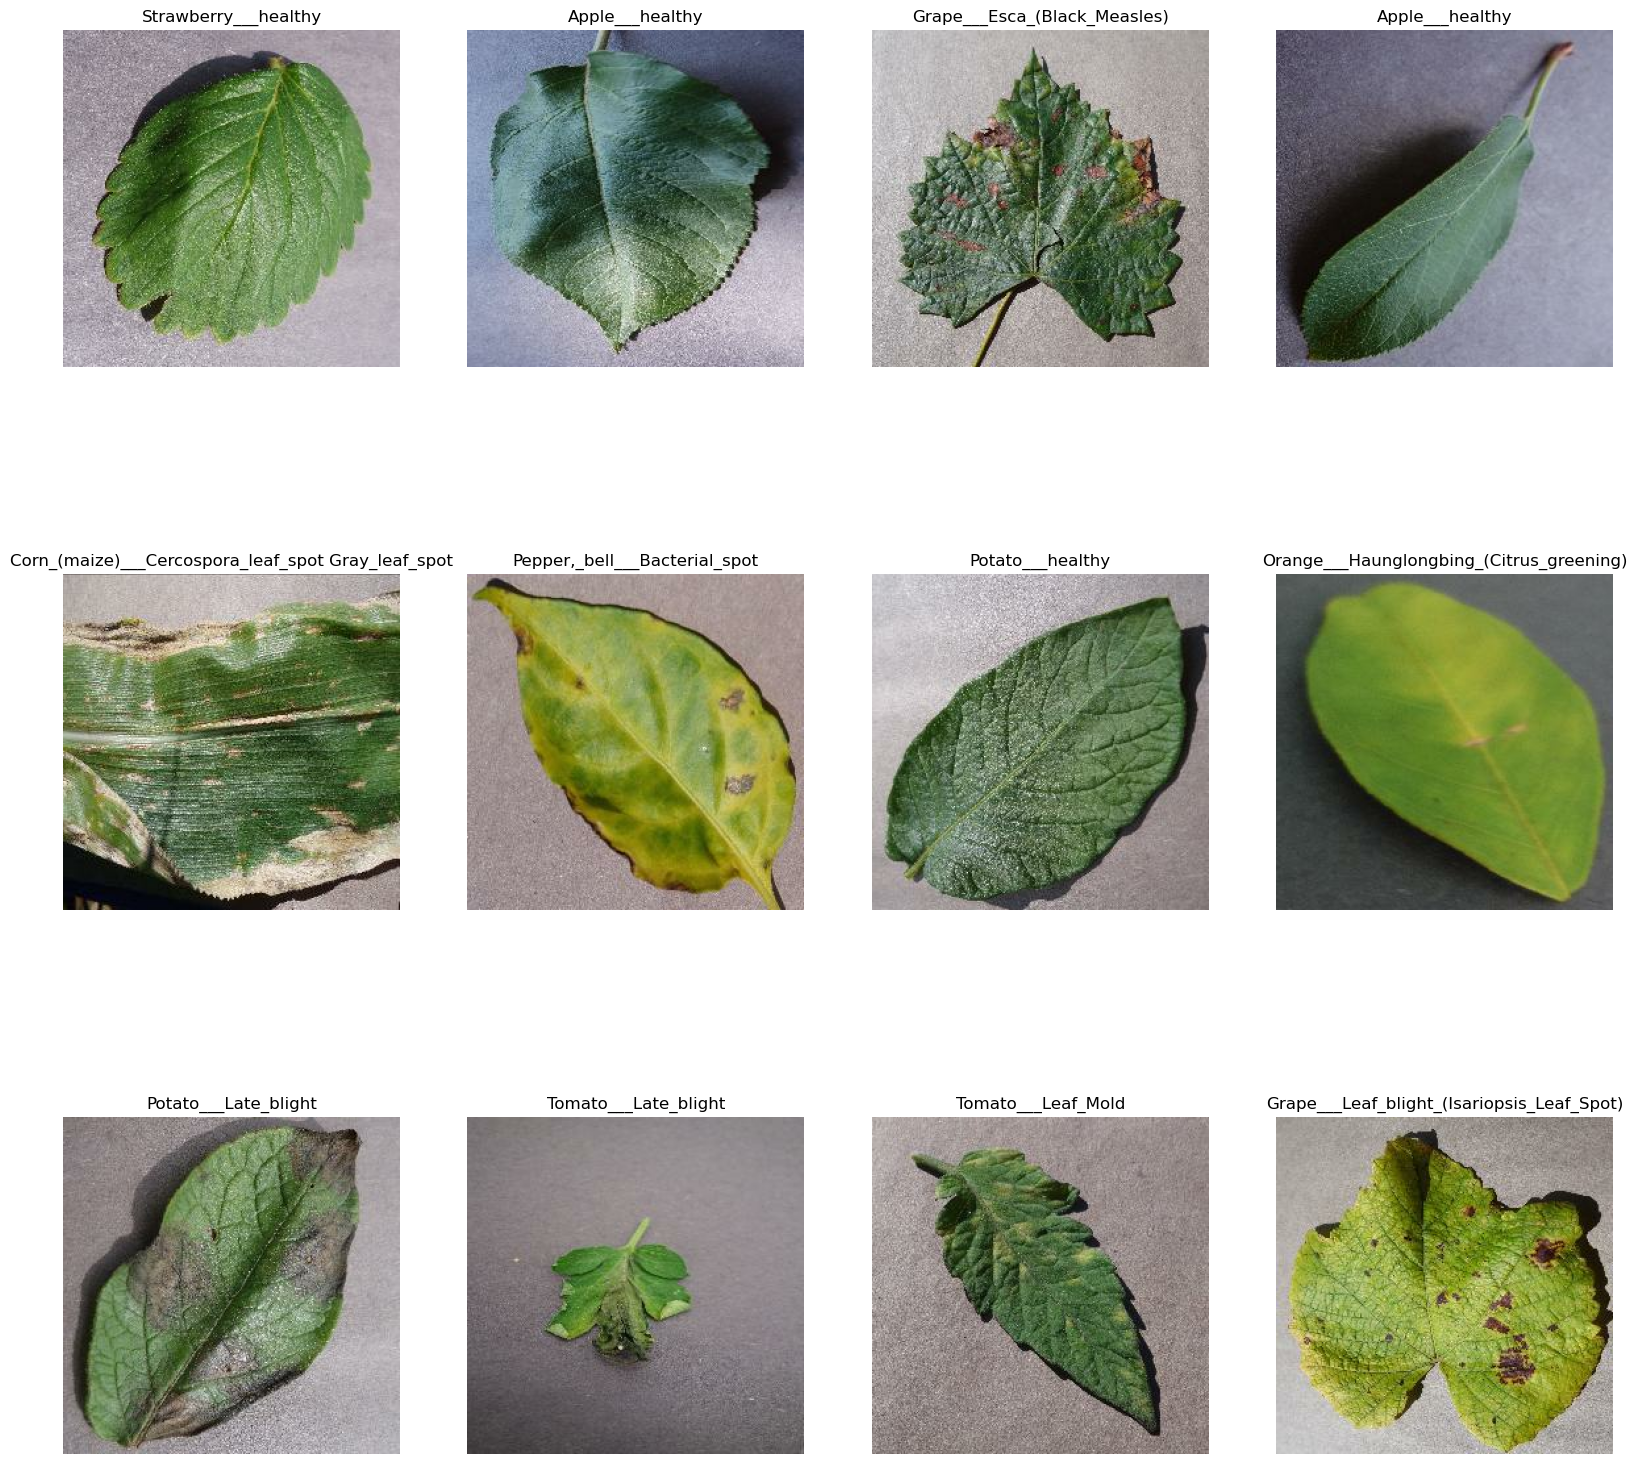

In [8]:
plt.figure(figsize=(20,20))
for image_batch,labels_batch in dataset.take(1):
    print(image_batch.shape)
    print(labels_batch.numpy())
    for i in range(12):
        ax=plt.subplot(3,4,i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")

In [9]:
train_size=0.8
len(dataset)*train_size

298.40000000000003

In [10]:
train_ds=dataset.take(298)
len(train_ds)

298

In [11]:
test_ds=dataset.skip(298)
len(test_ds)

75

In [12]:
val_size=0.1
len(dataset)*val_size


37.300000000000004

In [13]:
val_ds=test_ds.take(37)
len(val_ds)

37

In [14]:
test_ds=test_ds.skip(37)
len(test_ds)

38

In [15]:
def get_dataset_partitions_tf(ds,train_split=0.8,val_split=0.1,test_split=0.1,shuffle=True,shuffle_size=10000):
    assert(train_split+test_split+val_split)==1
    ds_size=len(ds)
    
    if shuffle:
        ds=ds.shuffle(shuffle_size,seed=12)
        
    train_size=int(train_split*ds_size)
    val_size=int(val_split*ds_size)
    
    train_ds=ds.take(train_size)
    val_ds=ds.skip(train_size).take(val_size)
    test_ds=ds.skip(train_size).skip(val_size)
    
    return train_ds,val_ds,test_ds

In [16]:
train_ds,val_ds,test_ds=get_dataset_partitions_tf(dataset)

In [17]:
len(train_ds)

298

In [18]:
len(val_ds)

37

In [19]:
len(test_ds)

38

In [20]:
train_ds=train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds=val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds=test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [21]:
for image_batch,labels_batch in dataset.take(1):
    print(image_batch[0].numpy()/255)

[[[0.54901963 0.47843137 0.47843137]
  [0.56078434 0.49019608 0.49019608]
  [0.61960787 0.54901963 0.54901963]
  ...
  [0.5568628  0.4862745  0.47843137]
  [0.6        0.5294118  0.52156866]
  [0.6313726  0.56078434 0.5529412 ]]

 [[0.46666667 0.39607844 0.39607844]
  [0.7294118  0.65882355 0.65882355]
  [0.6745098  0.6039216  0.6039216 ]
  ...
  [0.60784316 0.5372549  0.5294118 ]
  [0.5137255  0.44313726 0.43529412]
  [0.6039216  0.53333336 0.5254902 ]]

 [[0.6784314  0.60784316 0.60784316]
  [0.627451   0.5568628  0.5568628 ]
  [0.7137255  0.6431373  0.6431373 ]
  ...
  [0.70980394 0.6392157  0.6313726 ]
  [0.60784316 0.5372549  0.5294118 ]
  [0.7176471  0.64705884 0.6392157 ]]

 ...

 [[0.53333336 0.45490196 0.45882353]
  [0.56078434 0.48235294 0.4862745 ]
  [0.5764706  0.49803922 0.5019608 ]
  ...
  [0.5803922  0.5019608  0.5058824 ]
  [0.49019608 0.4117647  0.41568628]
  [0.57254905 0.49411765 0.49803922]]

 [[0.52156866 0.44313726 0.44705883]
  [0.5647059  0.4862745  0.49019608]


In [22]:
resize_and_rescale = tf.keras.Sequential([
    layers.experimental.preprocessing.Rescaling(IMAGE_SIZE,IMAGE_SIZE),
    layers.experimental.preprocessing.Rescaling(1.0/255)
])

In [23]:
data_augmentation=tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2),
])

In [24]:
input_shape=(BATCH_SIZE,IMAGE_SIZE,IMAGE_SIZE,CHANNELS)
n_classes=38
model=models.Sequential([
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(32,kernel_size=(3,3),activation='relu',input_shape=input_shape),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,kernel_size=(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,kernel_size=(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),

    layers.Conv2D(64,(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),

    layers.Flatten(),
    layers.Dense(64,activation='relu'),
    layers.Dense(n_classes,activation='softmax'),
])
model.build(input_shape=input_shape)

In [25]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 sequential_1 (Sequential)   (32, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (32, 127, 127, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (32, 62, 62, 64)         0         
 2D)                                                  

In [26]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [27]:
history=model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=EPOCHS
)

Epoch 1/10
298/298 [==============================] - 1624s 5s/step - loss: 3.1240 - accuracy: 0.1329 - val_loss: 2.7613 - val_accuracy: 0.2177
Epoch 2/10
298/298 [==============================] - 1018s 3s/step - loss: 2.2040 - accuracy: 0.3418 - val_loss: 2.2126 - val_accuracy: 0.3588
Epoch 3/10
298/298 [==============================] - 995s 3s/step - loss: 1.5762 - accuracy: 0.5163 - val_loss: 1.9468 - val_accuracy: 0.4430
Epoch 4/10
298/298 [==============================] - 1020s 3s/step - loss: 1.2210 - accuracy: 0.6169 - val_loss: 1.4611 - val_accuracy: 0.5383
Epoch 5/10
298/298 [==============================] - 1092s 4s/step - loss: 1.0159 - accuracy: 0.6791 - val_loss: 1.1691 - val_accuracy: 0.6361
Epoch 6/10
298/298 [==============================] - 1076s 4s/step - loss: 0.8816 - accuracy: 0.7182 - val_loss: 0.9536 - val_accuracy: 0.6990
Epoch 7/10
298/298 [==============================] - 1083s 4s/step - loss: 0.7608 - accuracy: 0.7506 - val_loss: 1.2186 - val_accuracy: 

In [28]:
scores=model.evaluate(test_ds)

38/38 [==============================] - 492s 2s/step - loss: 0.7697 - accuracy: 0.7640


In [29]:
scores


[0.7697402238845825, 0.7639802694320679]

In [31]:
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']
loss=history.history['loss']
val_loss=history.history['val_loss']


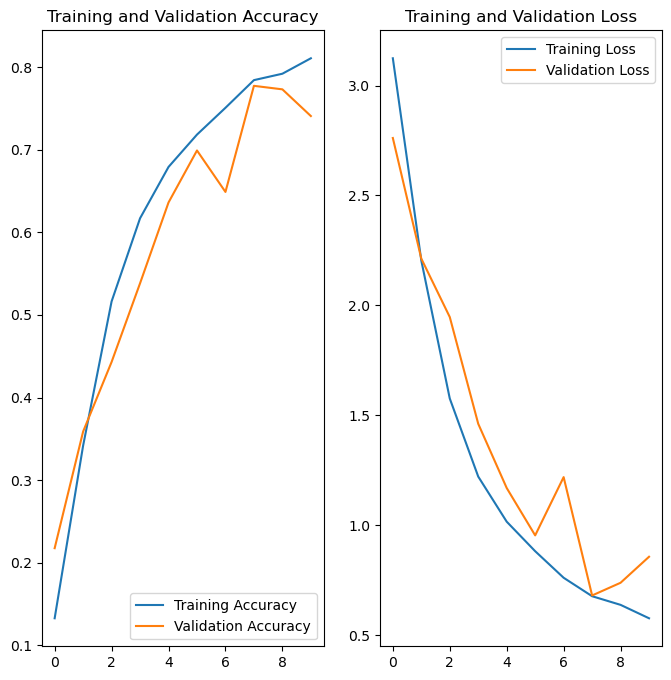

In [33]:
plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.plot(range(EPOCHS),acc,label='Training Accuracy')
plt.plot(range(EPOCHS),val_acc,label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1,2,2)
plt.plot(range(EPOCHS),loss,label='Training Loss')
plt.plot(range(EPOCHS),val_loss,label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

First image to predict
Actual Label :  Pepper,_bell___Bacterial_spot
1/1 [==============================] - 1s 793ms/step
Predicted Label :  Pepper,_bell___Bacterial_spot


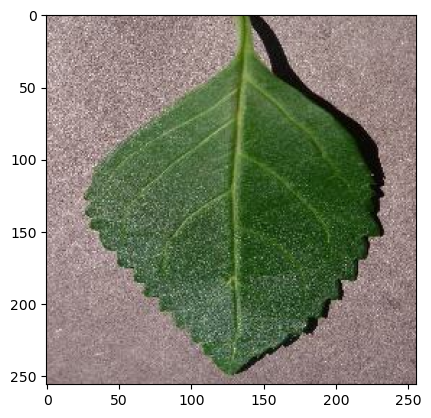

In [42]:
import numpy as np
for images_batch,labels_batch in test_ds.take(1):
    first_image=image_batch[0].numpy().astype("uint8")
    print("First image to predict")
    plt.imshow(first_image)
    print("Actual Label : ",class_names[labels_batch[0].numpy()])
    batch_prediction=model.predict(images_batch)
    print("Predicted Label : ",class_names[np.argmax(batch_prediction[0])])

In [52]:
def predict(model,img):
    img_array=tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array=tf.expand_dims(img_array,0)
    
    predictions=model.predict(img_array)
    
    predicted_class=class_names[np.argmax(predictions[0])]
    confidence=round(100*(np.max(predictions[0])),2)
    return predicted_class,confidence

1/1 [==============================] - 0s 91ms/step


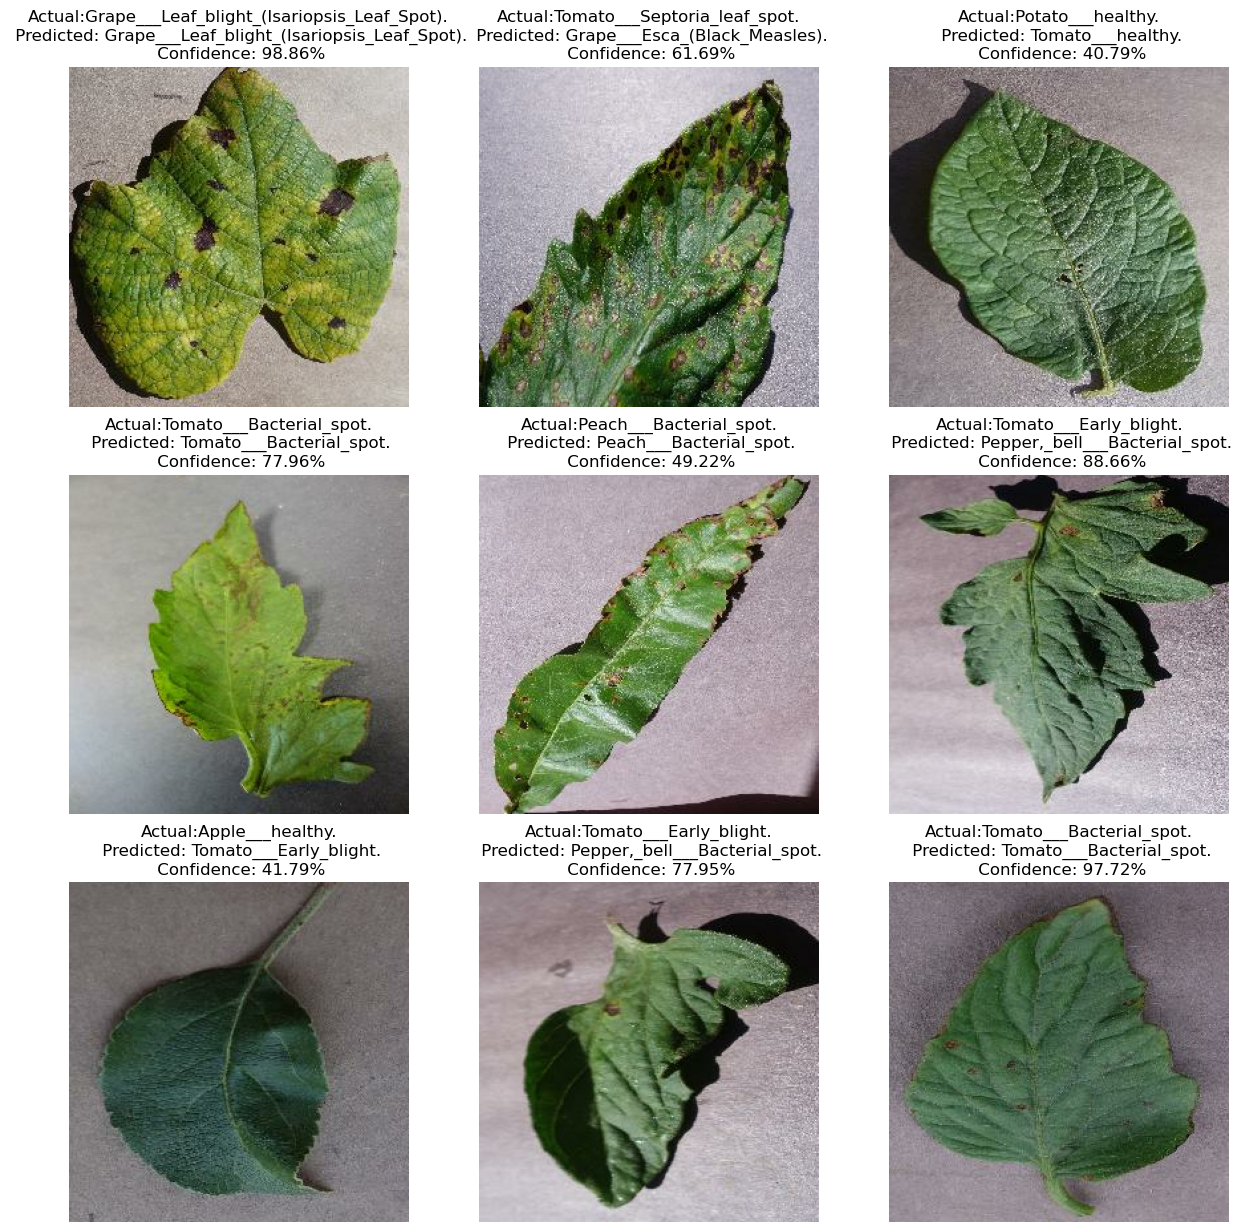

In [53]:
plt.figure(figsize=(15,15))
for images,labels in test_ds.take(1):
    for i in range(9):
        ax=plt.subplot(3,3,i+1)
        plt.imshow(images[i].numpy().astype("uint8"))
        predicted_class,confidence=predict(model,images[i].numpy())
        
        actual_class=class_names[labels[i]]
        plt.title(f"Actual:{actual_class}.\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        plt.axis("off")

In [61]:
import os
model_version = max([int(i) for i in (os.listdir("../saved_models")+[0])])+1
model.save(f"../saved_models/{model_version}")

INFO:tensorflow:Assets written to: ../saved_models/2\assets


INFO:tensorflow:Assets written to: ../saved_models/2\assets


1.23.5
